<a href="https://colab.research.google.com/github/SvetlanaErmakova/Analytics-and-statistics/blob/main/food_delivery(multifactorial_anova).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В компании по доставке готовых блюд проведен тест:

Была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый. Проверим, как пользователи отреагируют на изменение формата кнопки с разбивкой по сегменту клиента.

Проведем статистические тесты и сделаем выводы о влиянии этих 2ух факторов на количество заказов:

1.Визуализируем распределение events для test/control

2.Посчитаем среднее, медиану и стандратное отклонение в разбивке по группе и сегменту пользователя

3.Проведем тест и используя критерий Тьюки определим меж какими группами есть статистически значимые различия

4.Вывод

Описание данных:

•	id – id клиента в эксперименте

•	segment – сегмент (high/low)

•	group – вид кнопки (control – старая версия, test – новая версия)

•	events – сколько блюд суммарно было заказано за период


In [32]:
!pip install pingouin

In [33]:
import pandas as pd
import numpy as np

import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
sns.set(rc = {'figure.figsize': (12, 6)}, style = "whitegrid")

In [54]:
exp2 = pd.read_csv("button_test.csv")
exp2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


1.Визуализируем распределение events для test/control


<Axes: xlabel='events', ylabel='Count'>

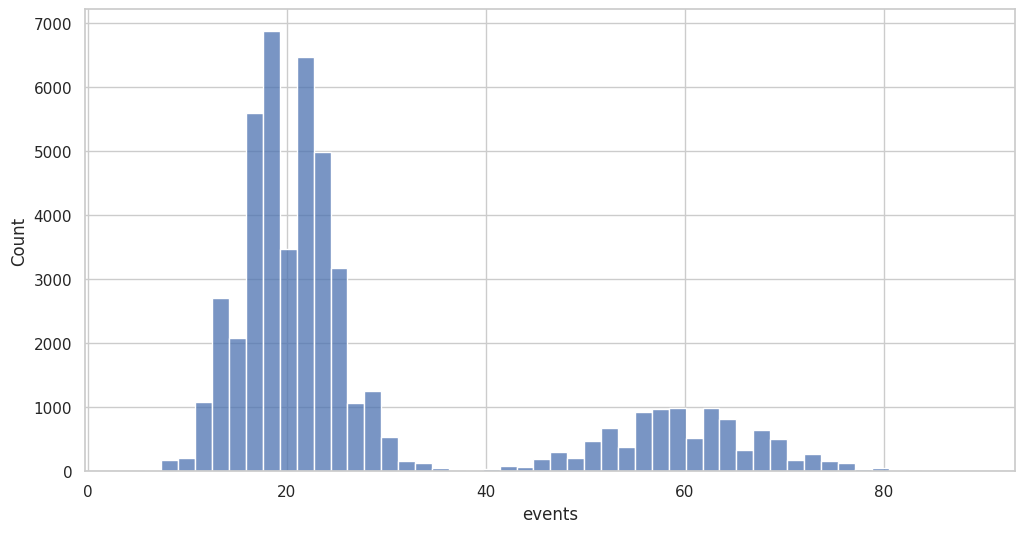

In [36]:
sns.histplot( x = exp2.query("group == 'control'").events, bins = 50)

<Axes: xlabel='events', ylabel='Count'>

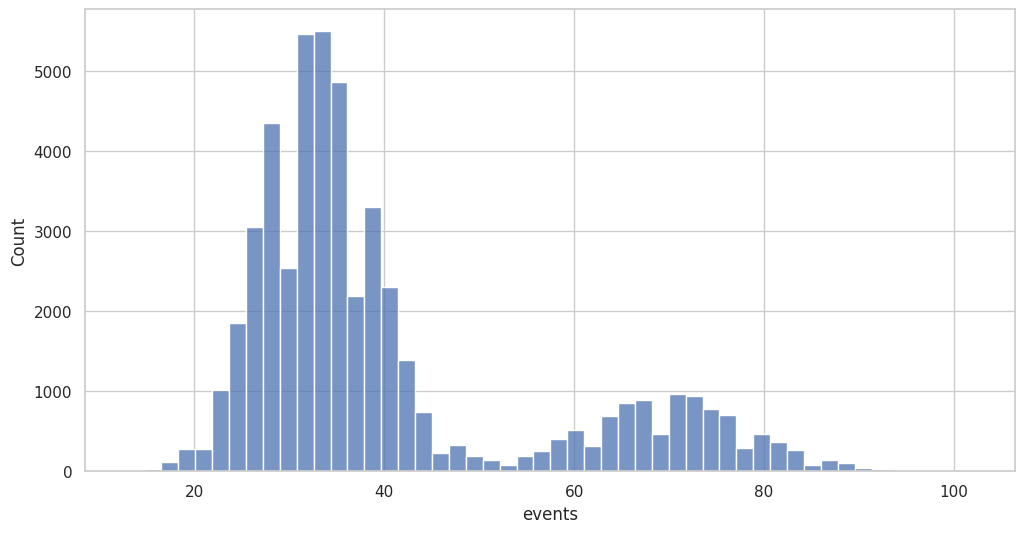

In [37]:
sns.histplot( x = exp2.query("group == 'test'").events, bins = 50)

2.Посчитаем среднее, медиану и стандратное отклонение в разбивке по группе и сегменту пользователя

In [38]:
exp2.groupby(['segment', 'group']).agg({'events':['mean', 'median', 'std']}).round(2)

events             
                  mean median   std
segment group                      
high    control  59.97   60.0  7.81
        test     69.94   70.0  8.40
low     control  20.03   20.0  4.47
        test     33.03   33.0  5.72

In [39]:
exp2.groupby(['segment', 'group'])['events'].describe().T.round(2)

segment      high                 low          
group     control      test   control      test
count    10000.00  10000.00  40000.00  40000.00
mean        59.97     69.94     20.03     33.03
std          7.81      8.40      4.47      5.72
min         31.00     40.00      4.00     13.00
25%         55.00     64.00     17.00     29.00
50%         60.00     70.00     20.00     33.00
75%         65.00     76.00     23.00     37.00
max         89.00    102.00     41.00     59.00

<ipython-input-40-ac7905b8ac18>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exp2.query("segment == 'low' & group == 'test' ").events, label = 'test');
<ipython-input-40-ac7905b8ac18>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exp2.query("segment == 'low' & group == 'control' ").events

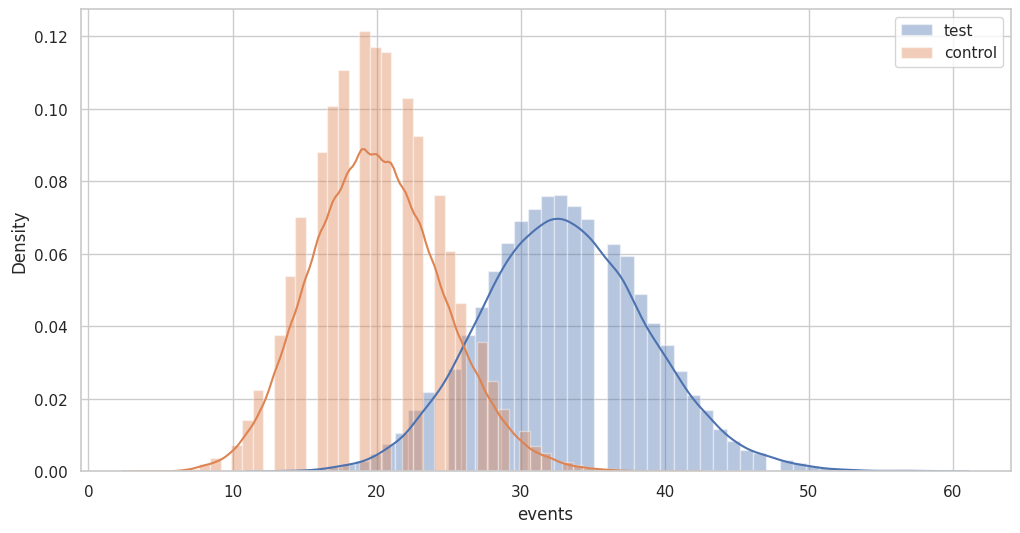

In [40]:
sns.distplot(exp2.query("segment == 'low' & group == 'test' ").events, label = 'test');
sns.distplot(exp2.query("segment == 'low' & group == 'control' ").events, label = 'control');
plt.legend();

<ipython-input-41-283361900595>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exp2.query("segment == 'high' & group == 'test' ").events, label = 'test')
<ipython-input-41-283361900595>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exp2.query("segment == 'high' & group == 'control' ").event

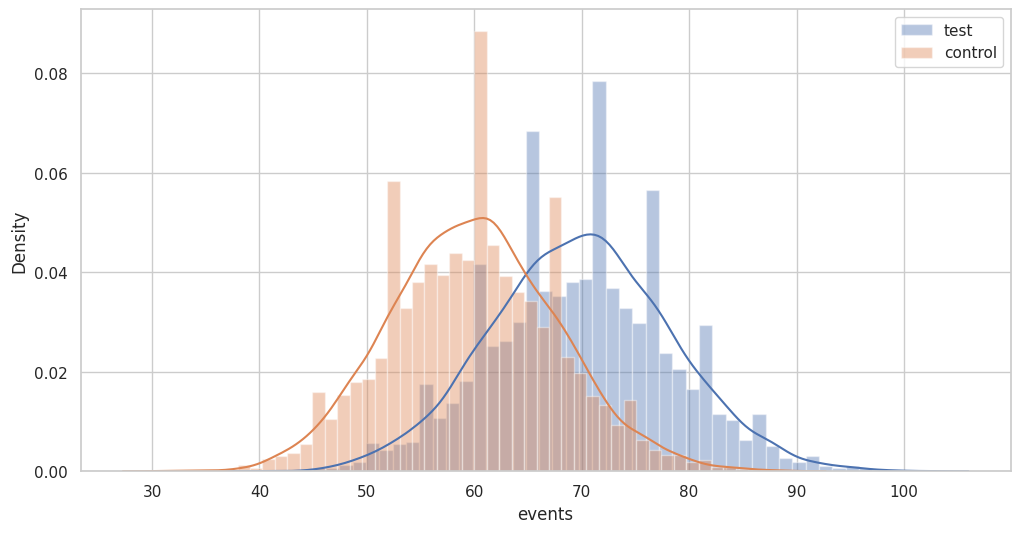

In [41]:
sns.distplot(exp2.query("segment == 'high' & group == 'test' ").events, label = 'test')
sns.distplot(exp2.query("segment == 'high' & group == 'control' ").events, label = 'control')
plt.legend()

3.Проведем тест и используя критерий Тьюки определим меж каким группами статистически значимые различия

statsmodels:

In [42]:
model = smf.ols(formula = 'events ~  segment + group + segment:group', data = exp2).fit()

In [43]:
aov_table = anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
segment,1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment:group,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


pingouin:

In [44]:
pg.anova(data = exp2, dv = "events", between = ['group', 'segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


<Axes: xlabel='group', ylabel='events'>

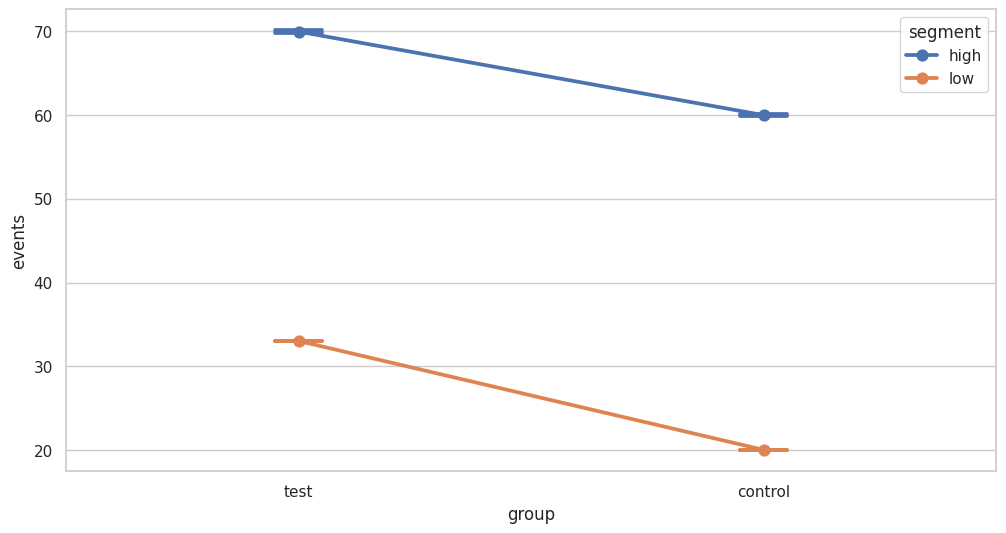

In [45]:
sns.pointplot(x = 'group', y = 'events', hue = 'segment', data = exp2, capsize = 0.1)

<Axes: xlabel='group', ylabel='events'>

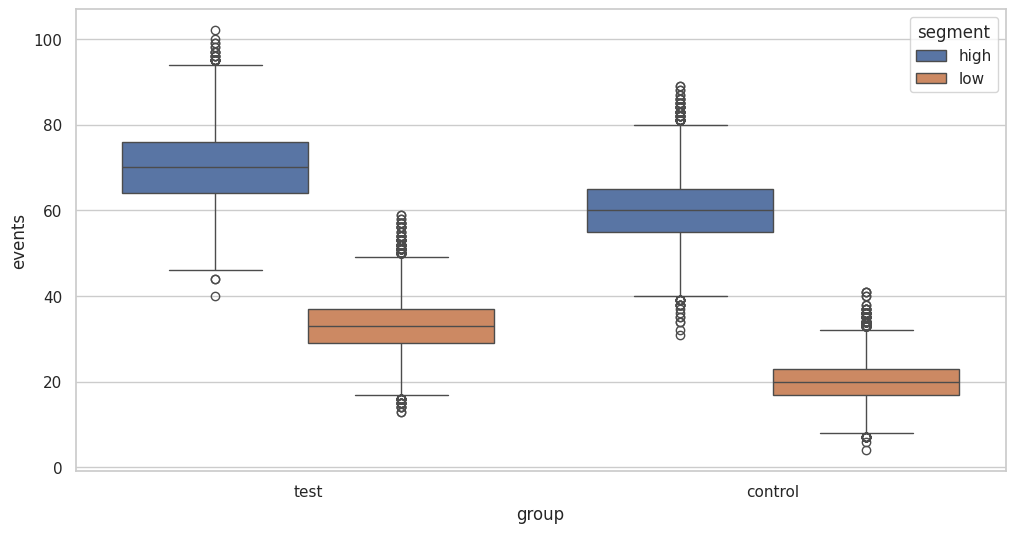

In [46]:
sns.boxplot(x = 'group', y = 'events', hue = 'segment', data = exp2)

Для последующего сравнения меж группами - соединим колонки group, segment водну колонку:

In [55]:
exp2['combination'] = exp2.group + "\\" + exp2.segment

In [49]:
exp2.combination

0          test\high
1          test\high
2          test\high
3          test\high
4          test\high
            ...     
99995    control\low
99996    control\low
99997    control\low
99998    control\low
99999    control\low
Name: combination, Length: 100000, dtype: object

Тест Тьюки:

In [56]:
pg.pairwise_tukey(data = exp2, dv = "events", between = "combination")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control\high,control\low,59.970800,20.031575,39.939225,0.065432,610.391461,0.0,7.521612
1,control\high,test\high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.0,-1.228989
2,control\high,test\low,59.970800,33.025925,26.944875,0.065432,411.798717,0.0,4.350026
3,control\low,test\high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.0,-9.091140
4,control\low,test\low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.0,-2.530414
5,test\high,test\low,69.938500,33.025925,36.912575,0.065432,564.135148,0.0,5.814008


4.Вывод

Фактор group, как и фактор segmant оказался значимым. Их взамодействие статистически значимо(ну а практически видим: np2 = 0.01).

Среднее значение для всех сегментов увеличилось - выкатываем новую версию!